# Process and grade LLM responses

In [1]:
import pandas as pd

In [5]:
RESULTS_WITH_UMS = "../../results/llama2-7b-chat/results-with-ums.tsv"
full_df = pd.read_csv(open(RESULTS_WITH_UMS, "r"))

In [6]:
import regex as re
pattern = re.compile("^um[0-9]+_.+")

features = [c for c in full_df.columns if pattern.match(c) is not None]

print("Num uncertainty measures:", len(features))
print(f"\n{features}")

Num uncertainty measures: 22

['um1_prediction_score', 'um1_prediction_softmax', 'um1_present_score', 'um1_absent_score', 'um1_present_softmax', 'um1_absent_softmax', 'um3_accuracy_by_kingdom', 'um3_accuracy_by_phylum', 'um3_accuracy_by_family', 'um3_accuracy_by_country', 'um3_accuracy_by_stateprovince', 'um4_phrasing_agreement', 'um4_phrasing_score_var', 'um5_record_count_by_kingdom', 'um5_record_count_by_phylum', 'um5_record_count_by_family', 'um6_taxqa_accuracy_by_phylum', 'um6_taxqa_accuracy_by_family', 'um6_taxqa_accuracy_by_genus', 'um7_taxqa_responses_by_phylum', 'um7_taxqa_responses_by_family', 'um7_taxqa_responses_by_genus']


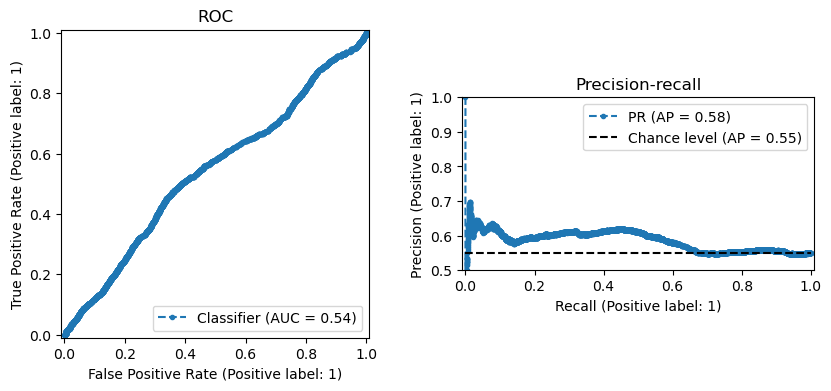

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
roc_args = {"marker":".", "linestyle":"--"}

train_df = full_df[full_df["train"]]
test_df = full_df[~full_df["train"]]

xgboost = HistGradientBoostingClassifier(
    loss='log_loss',
    # early_stopping=True,
    min_samples_leaf=1,
    max_iter=100,
    monotonic_cst=np.ones_like(features, dtype=int)
).fit(train_df[features], train_df["correct"]) # categorical_features=["stateprovince"]

f, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].title.set_text(f"ROC")
axes[1].title.set_text(f"Precision-recall")

probs = xgboost.predict_proba(test_df[features])
RocCurveDisplay.from_predictions(test_df["correct"], probs[:,1], ax=axes[0], **roc_args);
dis = PrecisionRecallDisplay.from_predictions(
    test_df["correct"], probs[:,1], name="PR", plot_chance_level=True, drop_intermediate=True, ax=axes[1], drawstyle="default", **roc_args
)
axes[1].set_ylim(0.5, 1)
axes[1].legend()
plt.show()

In [204]:
# train_df["certainty"] = xgboost.predict_proba(train_df[features])[:,1]
# train_df.to_csv("gpt4.tsv", sep="\t")